# Classical Bayesian optimisation

In [1]:
import jax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from jaxopt import ProjectedGradient
from rebayes_mini.methods import low_rank_last_layer as lrll

In [2]:
from bayesopt import test_functions, eval_fn, agents

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [5]:
jnp.set_printoptions(suppress=False, precision=8, linewidth=200)

In [6]:
%config InlineBackend.figure_format = "retina"

In [7]:
def plot_hist(ax, runs, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    
    ax.plot(med_run, **kwargs)
    ax.fill_between(steps, lbound, ubound, alpha=0.4)

In [8]:
key = jax.random.PRNGKey(31415)
key_init_params, key_run = jax.random.split(key)

## Branin (2d)

In [10]:
def objective_fn(x):
    return -test_functions.branin(x)

x_test = jnp.zeros(2)
dim = len(x_test)

def objective_fn(x):
    return -test_functions.hartmann6(x)
x_test = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
dim = len(x_test)

n_runs = 10

agent, bel_init_fn = agents.load_lrkf_agent(
    x_test, rank=50, cov=1.0, obs_noise=0.0, dynamics_cov=0.0, low_rank_diag=False,
)

agent, bel_init_fn = agents.load_ll_lrkf_agent(
    x_test, rank=50,
    cov_hidden=1e-4, # parameters do not vary much from their initial parameters
    cov_last=0.1, # uncertainty in target
    low_rank_diag=False,
)

rank = 50
agent, bel_init_fn = agents.load_lofi_agent(
    x_test, rank=rank, cov_init=1e-6, obs_noise=0.01, dynamics_covariance=1e-5
)

%%time
n_steps = 40
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs_lrkf = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
runs_lrkf = jax.tree.map(np.array, runs_lrkf)

UsageError: Line magic function `%%time` not found.


In [ ]:
fig, ax = plt.subplots()
plot_hist(ax, runs_lrkf["y_best"])
plt.title(f"Hartmann ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

In [ ]:
%run ./bayesopt/eval_bayesopt.py

In [138]:
jax.tree.map(jnp.shape, res)

{'FLoRES': {'x': (10, 40, 5), 'y': (10, 40), 'y_best': (10, 40)},
 'LRKF': {'x': (10, 40, 5), 'y': (10, 40), 'y_best': (10, 40)},
 'LoFi': {'x': (10, 40, 5), 'y': (10, 40), 'y_best': (10, 40)}}

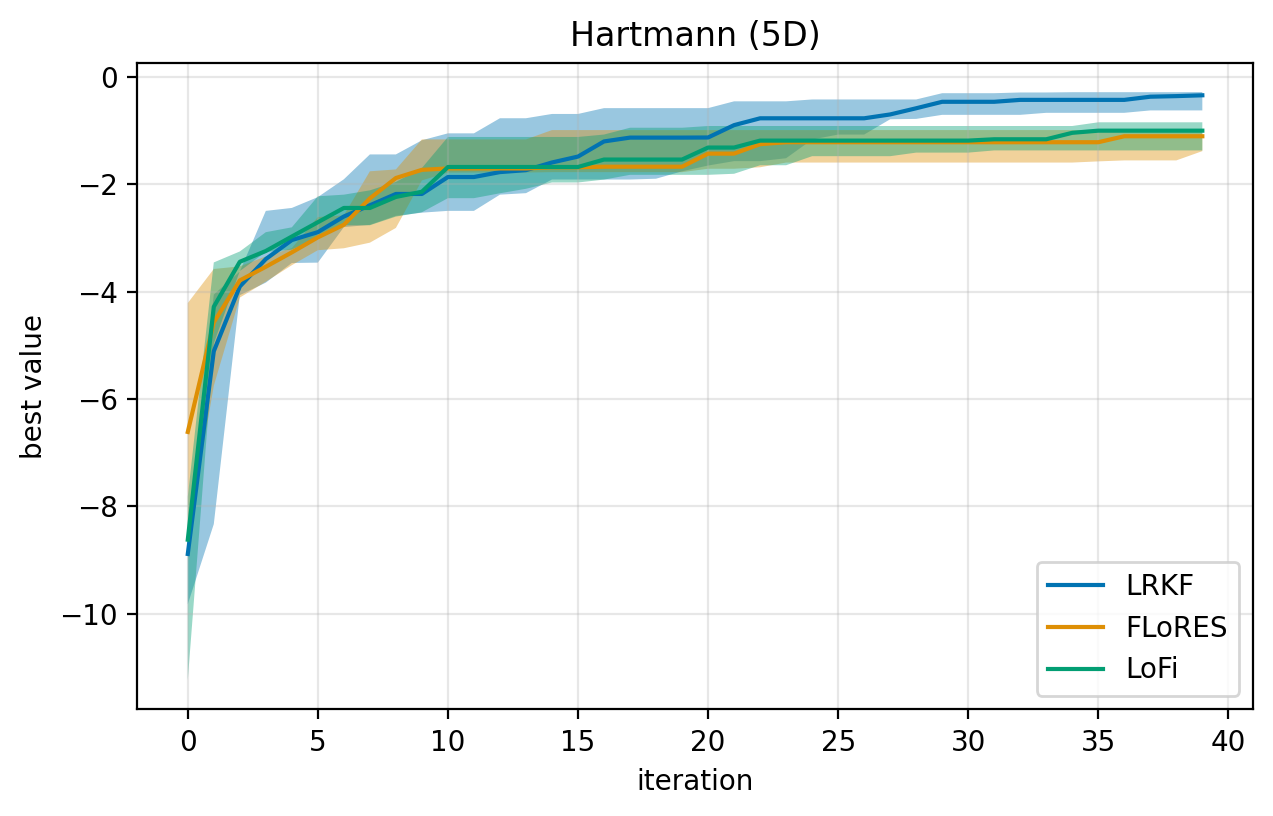

In [139]:
fig, ax = plt.subplots()
for name in res:
    runs = res[name]
    plot_hist(ax, runs["y_best"], label=name)
plt.legend()
plt.title(f"Hartmann ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)

# plt.xticks(np.arange(0, 110, 10));

## Hartmann function (6D)

In [72]:
def objective_fn(x):
    return -test_functions.hartmann6(x)
x_test = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
dim = len(x_test)

In [73]:
surrogate = eval_fn.MLPSurrogate()
params_init = surrogate.init(key_init_params, x_test)

def cov_fn(y): return 0.0 # Function interpolation does not require observation noise
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-4, # parameters do not vary much from their initial parameters
    cov_last=0.1, # uncertainty in target
    low_rank_diag=False,
)

In [ ]:
%%time
n_steps = 100
n_runs = 20
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs = eval_fn.test_runs(keys, n_steps, agent, bel_init, objective_fn, dim, lbound, ubound, dim)
runs = jax.tree.map(np.array, runs)
bel_runs = runs[0]
runs = runs[1]

In [ ]:
fig, ax = plt.subplots()
plot_hist(ax, runs["y_best"])
plt.grid(alpha=0.3)
plt.title("Hartmann (6D)")
plt.ylabel("best value")
plt.xlabel("iteration")
# plt.xticks(np.arange(0, 110, 10));

## Ackley (5D)

In [17]:
def objective_fn(x):
    return -test_functions.ackley(x, lbound=0, ubound=1.0)
x_test = jnp.zeros(5)
dim = len(x_test)

7.1525574e-07


In [19]:
surrogate = eval_fn.MLPSurrogate()
params_init = surrogate.init(key_init_params, x_test)

def cov_fn(y): return 0.0 # Function interpolation does not require observation noise
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-4, # parameters do not vary much from their initial parameters
    cov_last=1.0, # uncertainty in target
    low_rank_diag=False,
)

In [20]:
%%time
n_steps = 100
n_runs = 20 # choose 20
lbound, ubound = -5, 10
keys = jax.random.split(key_run, n_runs)
runs = eval_fn.test_runs(keys, n_steps, agent, bel_init, objective_fn, dim, lbound, ubound, dim)
runs = jax.tree.map(np.array, runs)
bel_runs = runs[0]
runs = runs[1]

CPU times: user 17 s, sys: 357 ms, total: 17.4 s
Wall time: 8.02 s


(-15.157485389709473, 0.0)

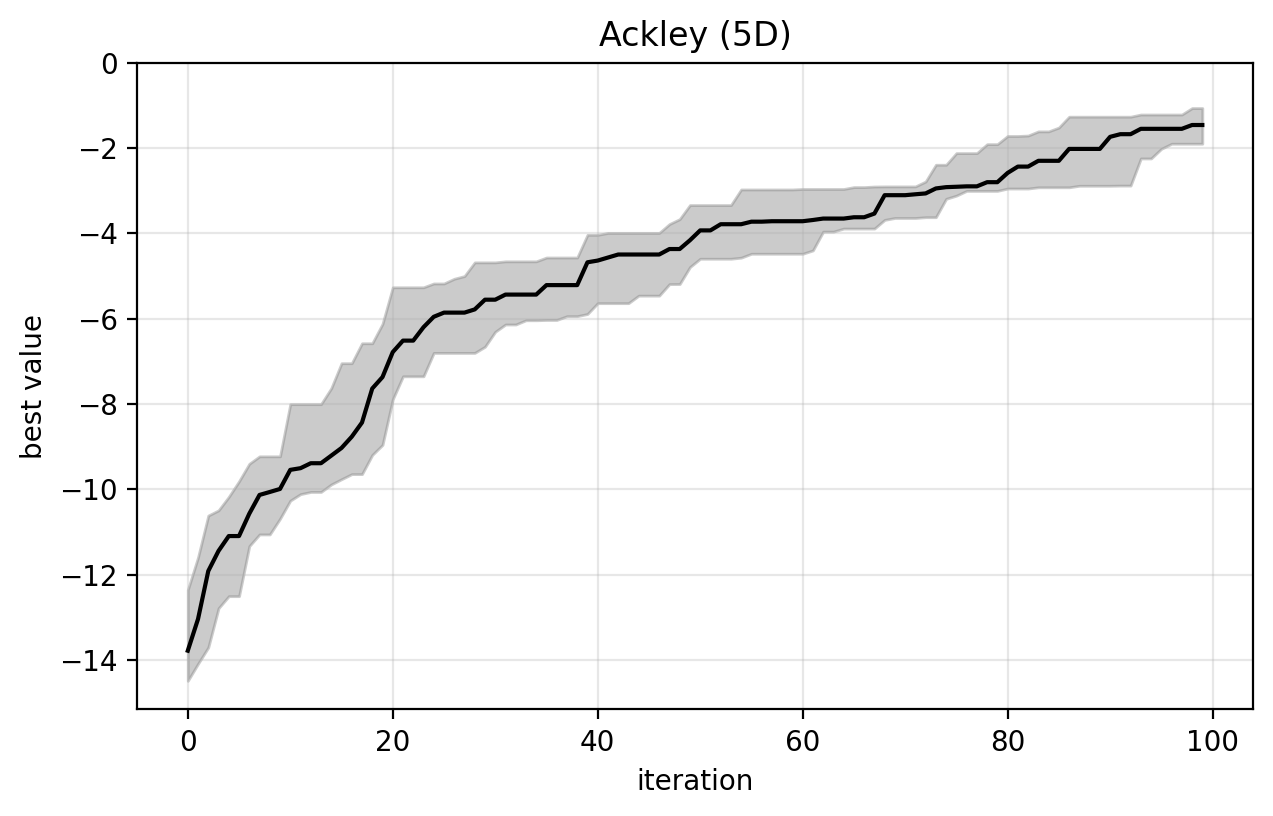

In [21]:
fig, ax = plt.subplots()
plot_hist(ax, runs["y_best"])
plt.grid(alpha=0.3)
plt.title(f"Ackley ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.ylim(top=0)
# plt.yticks(np.arange(-10, 1, 1));

## Ackley (2D)

In [22]:
def objective_fn(x):
    return -test_functions.ackley(x, lbound=0, ubound=1.0)
x_test = jnp.zeros(2)
dim = len(x_test)

In [23]:
surrogate = eval_fn.MLPSurrogate()
params_init = surrogate.init(key_init_params, x_test)

def cov_fn(y): return 0.0 # Function interpolation does not require observation noise
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-4, # parameters do not vary much from their initial parameters
    cov_last=1.0, # uncertainty in target
    low_rank_diag=False,
)

In [24]:
%%time
n_steps = 50
n_runs = 20 # choose 20
lbound, ubound = -5, 10
keys = jax.random.split(key_run, n_runs)
runs = eval_fn.test_runs(keys, n_steps, agent, bel_init, objective_fn, dim, lbound, ubound, dim)
runs = jax.tree.map(np.array, runs)
bel_runs = runs[0]
runs = runs[1]

CPU times: user 17.3 s, sys: 903 ms, total: 18.2 s
Wall time: 6.45 s


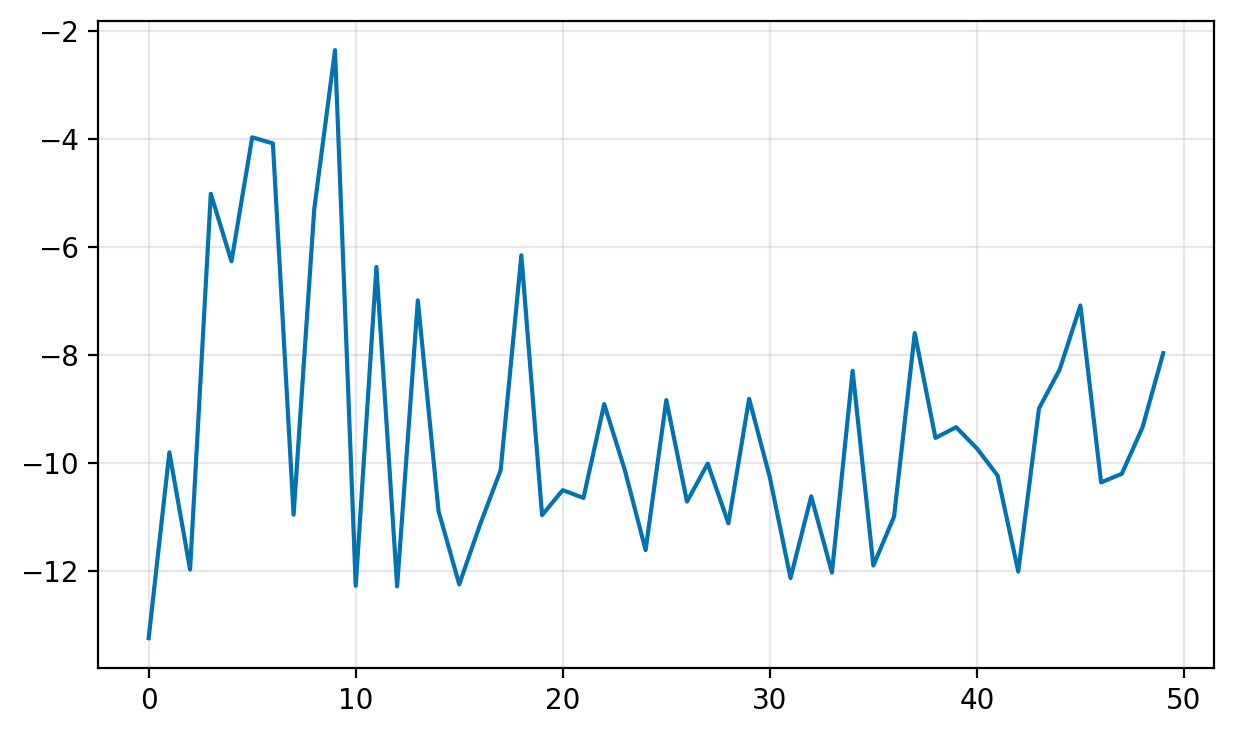

In [25]:
plt.plot(jnp.quantile(runs["y"], 0.5, axis=0))
plt.grid(alpha=0.3)

(-12.99080674648285, 0.0)

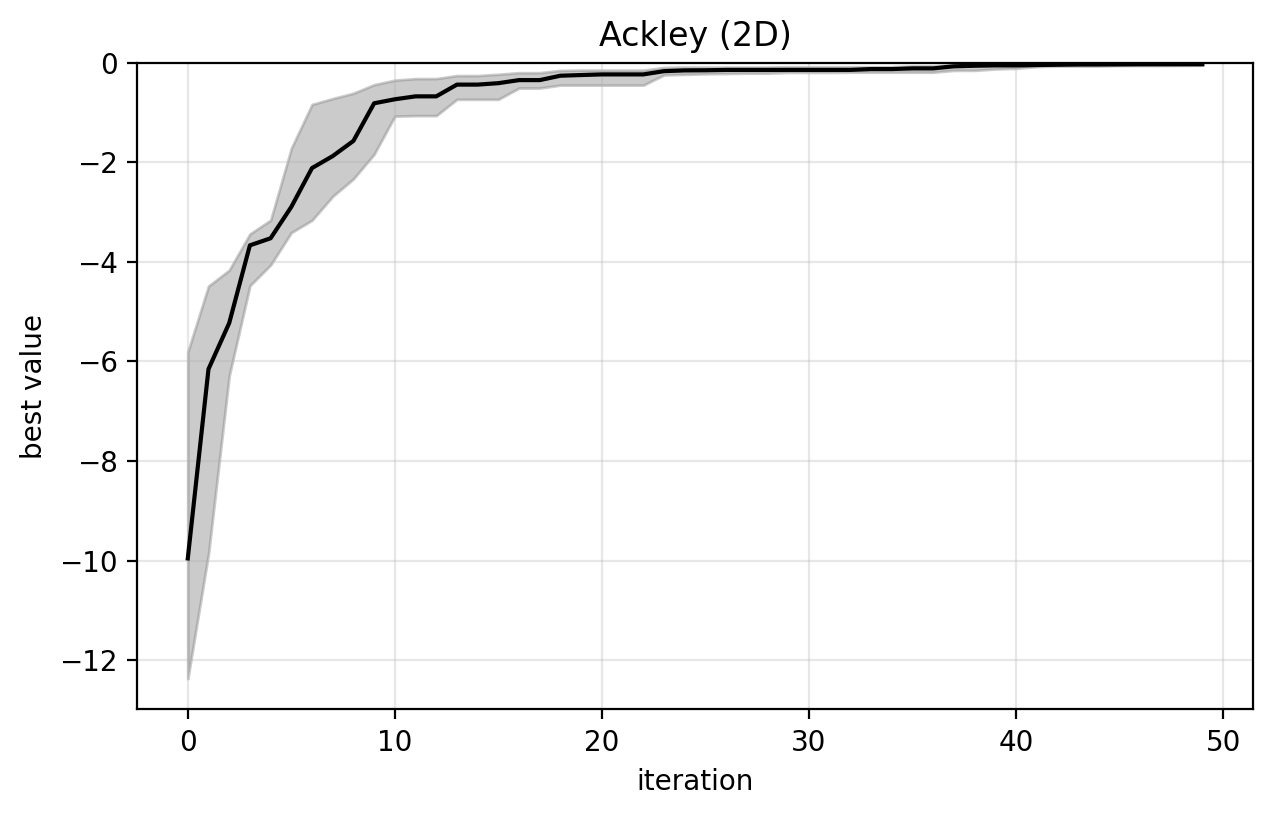

In [26]:
fig, ax = plt.subplots()
plot_hist(ax, runs["y_best"])
plt.grid(alpha=0.3)
plt.title(f"Ackley ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.ylim(top=0)
# plt.yticks(np.arange(-10, 1, 1));

### Ackley 2d: single run

In [28]:
surrogate = eval_fn.MLPSurrogate()
params_init = surrogate.init(key_init_params, x_test)

def cov_fn(y): return 0.0 # Function interpolation does not require observation noise
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-3, # parameters do not vary much from their initial parameters
    cov_last=1.0, # uncertainty in target
    low_rank_diag=False,
)

In [29]:
%%time
n_steps = 50
lbound, ubound = -5, 10
run = eval_fn.test_run(key_run, n_steps, agent, bel_init, objective_fn, dim, lbound, ubound, dim)
bel, run = jax.tree.map(np.array, run)

CPU times: user 10.9 s, sys: 491 ms, total: 11.4 s
Wall time: 6.02 s


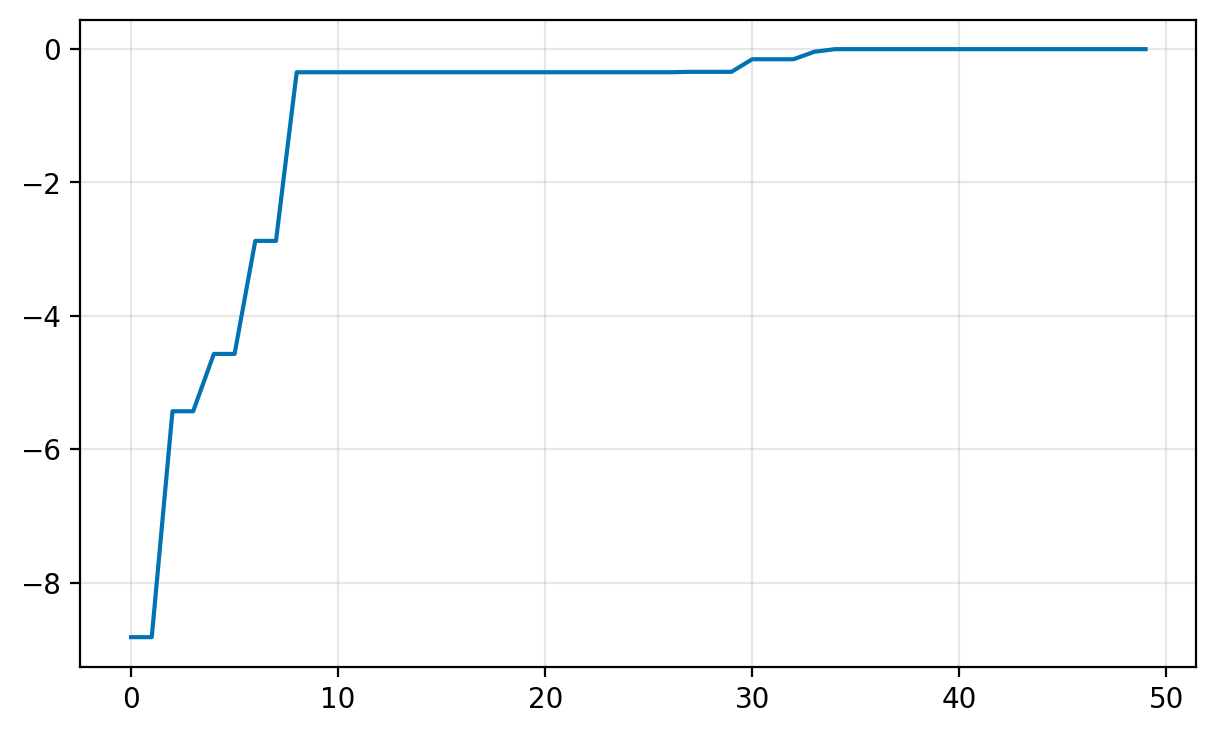

In [30]:
plt.plot(run["y_best"])
plt.grid(alpha=0.3)

In [31]:
lims = np.linspace(-5, 10, 100)
X = np.mgrid[-5:10:100j, -5:10:100j]
sim = 1
bel = jax.tree.map(lambda x: x[sim], bel_runs)

@partial(jax.vmap, in_axes=(None, None, 1))
@partial(jax.vmap, in_axes=(None, None, 1))
def veval(phidden, plast, X):
    return agent.mean_fn(phidden, plast, X).squeeze()


@partial(jax.vmap, in_axes=(1,))
@partial(jax.vmap, in_axes=(1,))
def vtrue(X):
    return objective_fn(X)

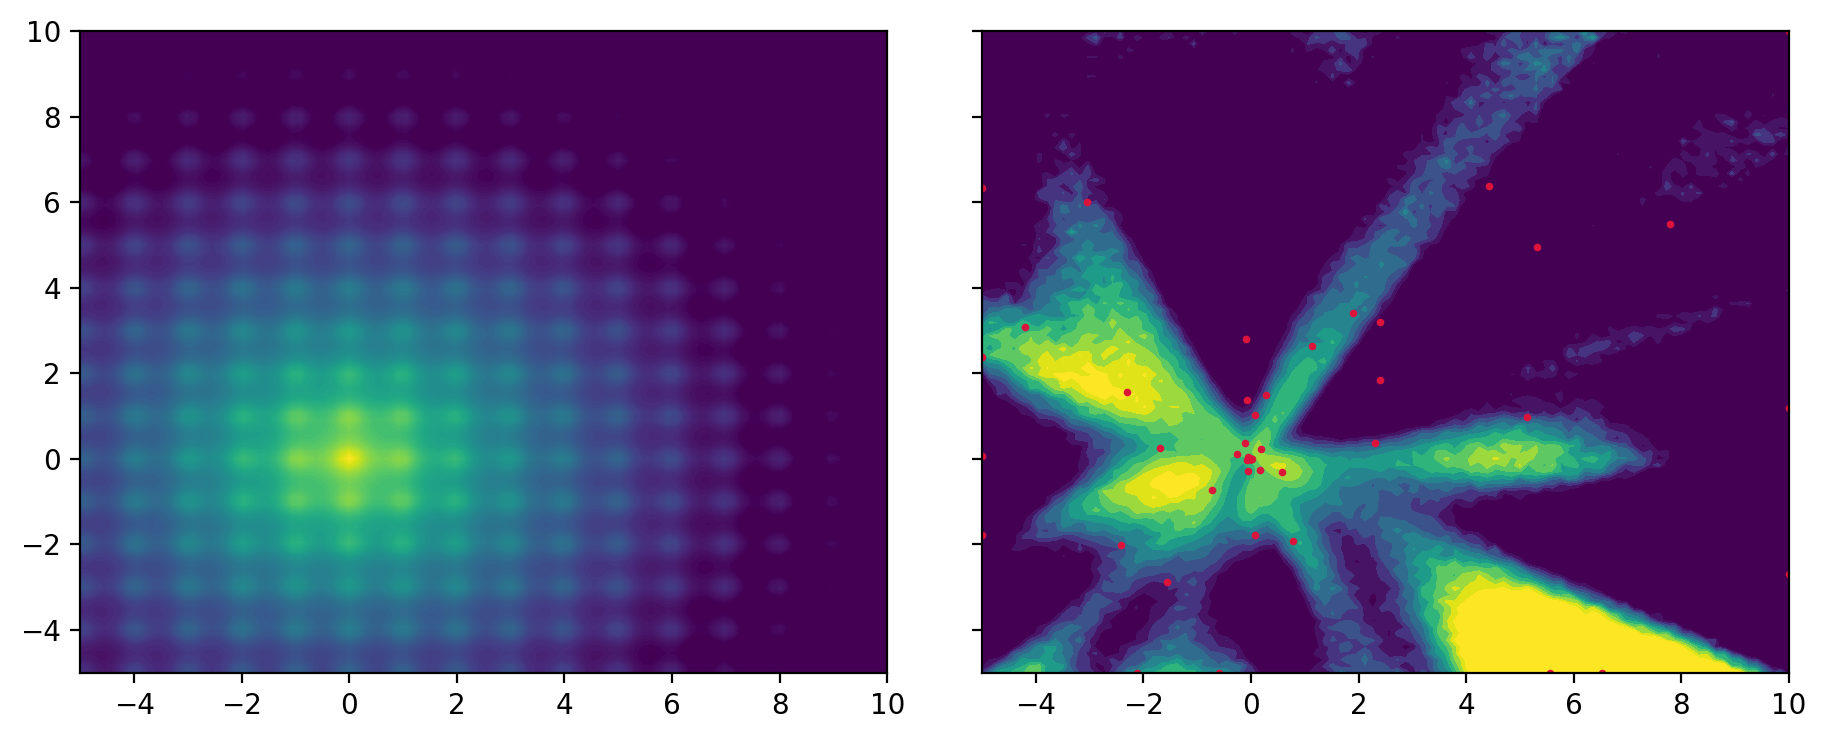

In [32]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6.2 * 1.5, 3.8))

levels = 100
axs[0].contourf(lims, lims, vtrue(X), vmin=-15, vmax=0.0, levels=levels)
axs[1].contourf(lims, lims, veval(bel.mean_hidden, bel.mean_last, X), vmin=-15, vmax=0.0, levels=levels)
axs[1].scatter(*run["x"].T, c="crimson", s=3)
plt.tight_layout()

## Ackley 1d: Gaussian process with Matern Kernel

In [50]:
def objective_fn(x):
    return -test_functions.ackley(x, lbound=0, ubound=1.0)
x_test = jnp.zeros(1)
dim = len(x_test)

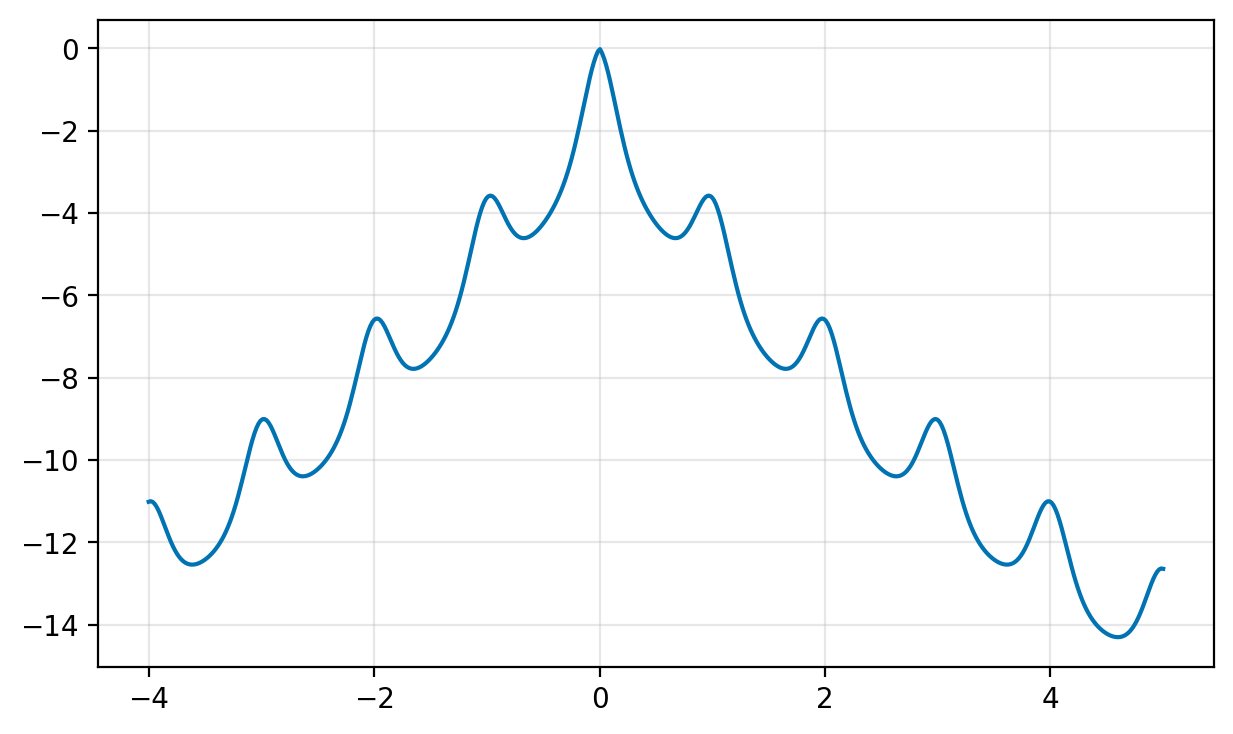

In [51]:
x_test = jnp.linspace(-4, 5, 500)[:, None]
y_test = jax.vmap(objective_fn)(x_test)
plt.plot(x_test, y_test)
plt.grid(alpha=0.3)

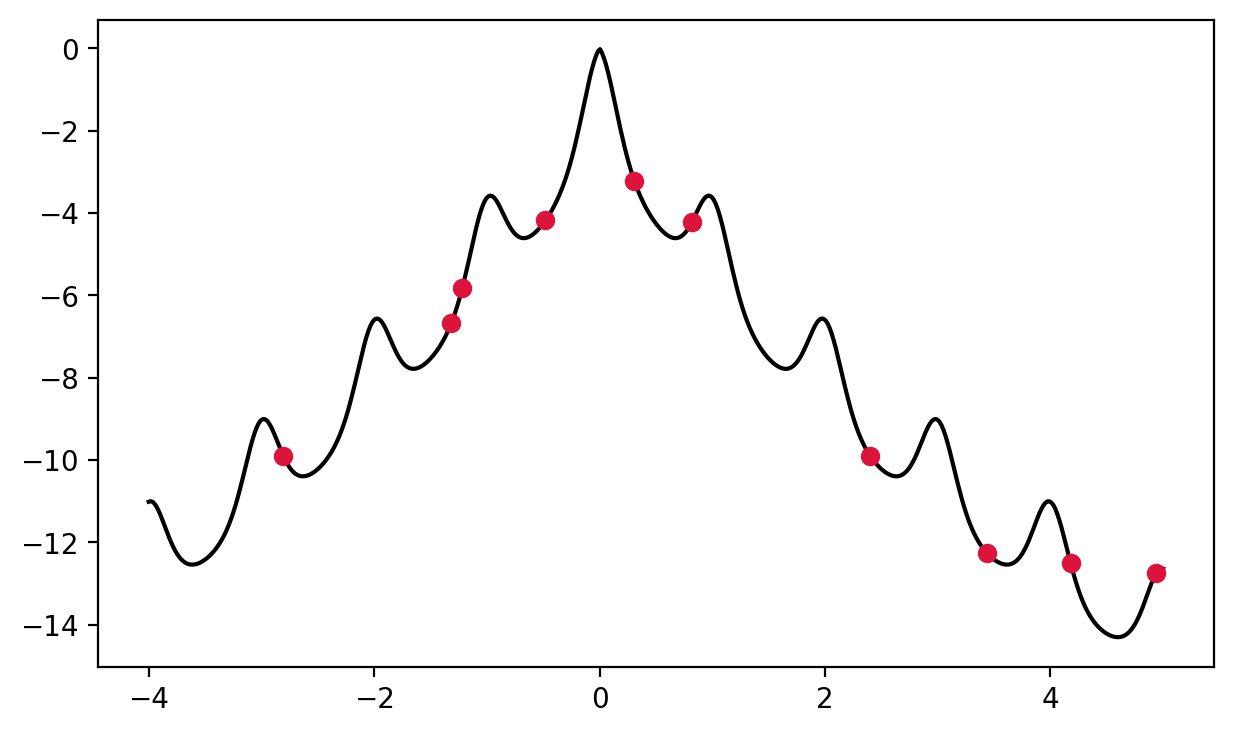

In [52]:
key = jax.random.PRNGKey(314)
x = jax.random.uniform(key, minval=-4, maxval=5, shape=(10,))[:, None]
y = jax.vmap(objective_fn)(x)

plt.scatter(x, y, c="crimson")
plt.plot(x_test, y_test, c="black", zorder=0)

## Bayesopt

In [140]:
@partial(jax.vmap, in_axes=(0, None, None))
def eval_fn(key, bel, x):
    fn = agent.sample_fn(key, bel)
    return fn(x)

y_samples = eval_fn(keys, bel, x_test).squeeze()

In [141]:
from rebayes_mini.methods import gaussian_process as gp

In [142]:
keys = jax.random.split(key, 20)

In [143]:
kernel = gp.matern_kernel(length_scale=0.5, nu=5/2)
agent = gp.GaussianProcessRegression(obs_variance=0.0, kernel=kernel)
bel_init = agent.init_bel(dim_in=1, buffer_size=10)

In [144]:
bel, _ = agent.scan(bel_init, y, x)

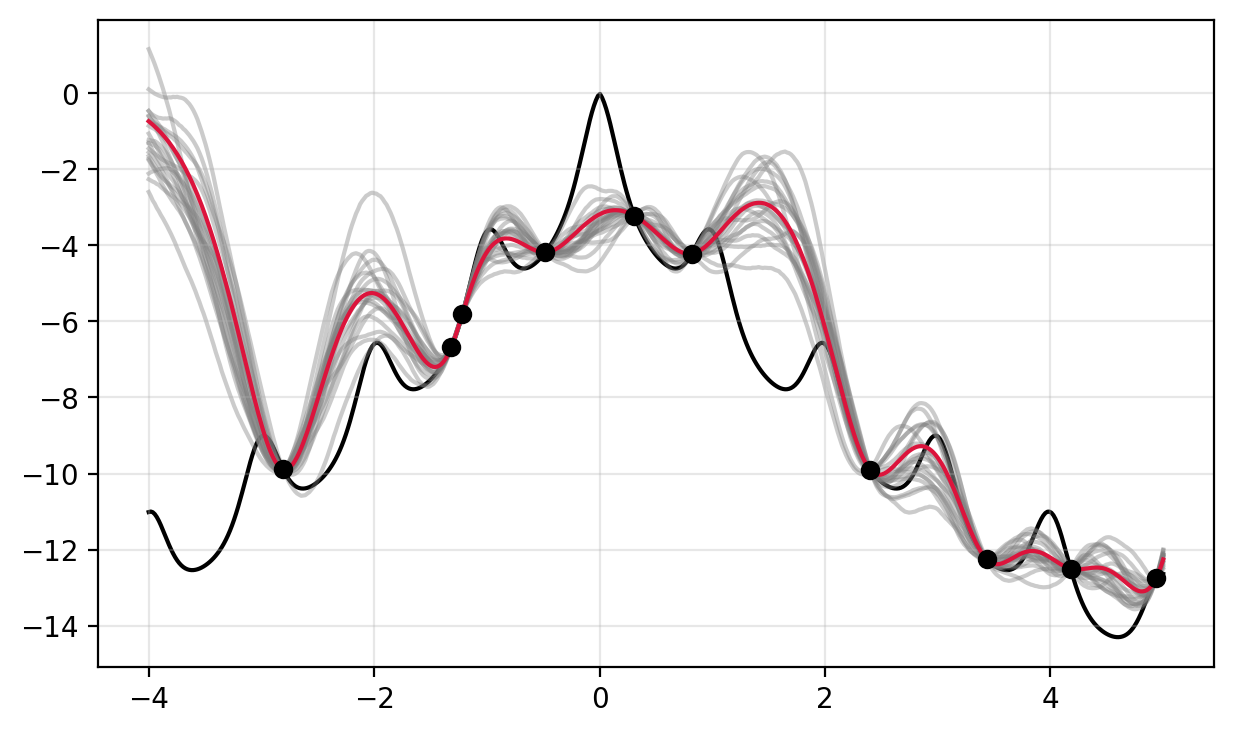

In [145]:
plt.plot(x_test, y_test, c="black", zorder=0)
plt.plot(x_test, agent.mean_fn(bel, x_test), c="crimson")
plt.scatter(x, y, c="black", zorder=3)
plt.grid(alpha=0.3)
plt.plot(x_test, y_samples.T, c="tab:gray", alpha=0.4, zorder=0);

## Simple test

In [43]:
from rebayes_mini.methods import gaussian_process as gp

In [44]:
x_test = jnp.linspace(0, 1.2, 200)[:, None]
x = jnp.array([0.1, 0.2, 0.25, 0.8, 0.9])[:, None]
y = jnp.array([1.3, 1.1, 0.9, 0.85, 0.6])

In [45]:
kernel = gp.gaussian_kernel(sigma2=0.01)
agent = gp.GaussianProcessRegression(obs_variance=0.0, kernel=kernel)
bel_init = agent.init_bel(dim_in=1, buffer_size=10)
bel, _ = agent.scan(bel_init, y, x)

In [46]:
keys = jax.random.split(key, 20)

In [47]:
@partial(jax.vmap, in_axes=(0, None, None))
def eval_fn(key, bel, x):
    fn = agent.sample_fn(key, bel)
    return fn(x)

In [48]:
y_samples = eval_fn(keys, bel, x_test).squeeze()

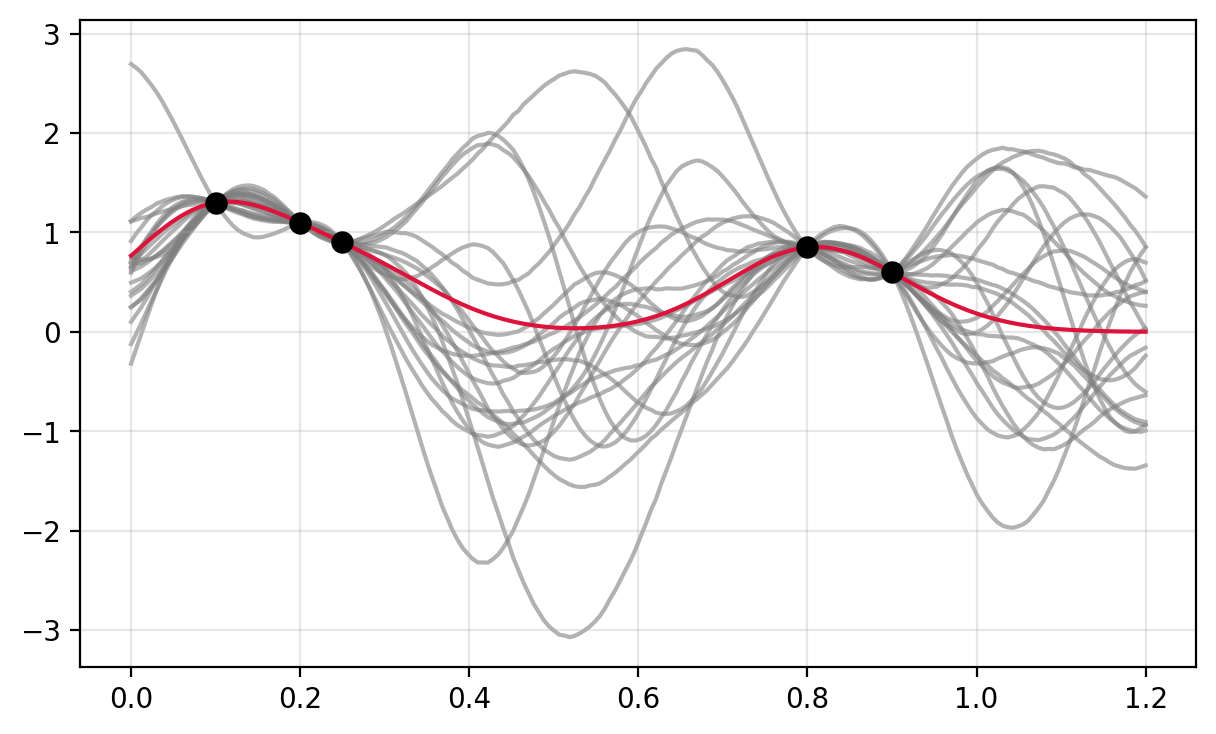

In [49]:
yhat = agent.mean_fn(bel, x_test)
plt.scatter(x, y, c="black", s=50, zorder=3)
plt.plot(x_test, yhat, c="crimson")
plt.plot(x_test, y_samples.T, c="tab:gray", alpha=0.6, zorder=0)
plt.grid(alpha=0.3)